    Install modules

In [7]:
import rasterio
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

from rasterio.plot import show

Load raster data

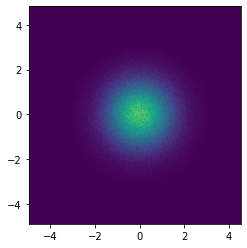

In [22]:
x = np.random.randn(1000000)
y = np.random.randn(1000000)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=(500, 650))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()